# Part 2: Handling the Cold Start Problem with Content-Based Filtering

Collaborative filtering relies solely on user-item interactions within the utility matrix. The issue with this approach is that brand new users or items with no interactions get excluded from the recommendation system. This is called the "cold start" problem. Content-based filtering is a way to handle this problem by generating recommendations based on user and item features.

In this tutorial, we will generate item-item recommendations using content-based filtering.

### Step 1: Import Dependencies

We will be using the following Python packages:

- [numpy](https://numpy.org/): for scientific computing 
- [pandas](https://pandas.pydata.org/): for data manipulation 
- [scikit-learn](https://scikit-learn.org/stable/): for machine learning 
- [matplotlib](https://matplotlib.org/), [seaborn](https://seaborn.pydata.org/): for data visualization

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Step 2: Load the Data

Let's assume we're building a recommender system for a new movie platform and we know very little about our current users. We don't have enough interactios data in our system to rely on collaborative filtering. 

What we do have is movie features: which genres a movie belongs to, and which year it was released. 

In [2]:
# movies = pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv")
movies = pd.read_csv("./data/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Step 3: Data Cleaning and Exploration

Before exploring our movie features dataset, we need to clean in two ways:

1. Genres is expressed as a string with a pipe | separating each genre. We will manipulate this string into a list, which will make it much easier to analyze.
2. Title currently has (year) appended at the end. We will extract year from each title string and create a new column for it.

#### Converting Genres from String Format to List 

The genres column is currently a string separated with pipes. Let's convert this into a list using the "split" function.

We want 
`"Adventure|Children|Fantasy"`
to convert to this:
`[Adventure, Children, Fantasy]`.

In [3]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


#### How many movie genres are there?

We can use Python's Counter to create a dictionary containing frequency counts of each genre in our dataset.

In [4]:
from collections import Counter

genres_counts = Counter(g for genres in movies['genres'] for g in genres)
print(f"There are {len(genres_counts)} genre labels.")
genres_counts

There are 20 genre labels.


Counter({'Drama': 4361,
         'Comedy': 3756,
         'Thriller': 1894,
         'Action': 1828,
         'Romance': 1596,
         'Adventure': 1263,
         'Crime': 1199,
         'Sci-Fi': 980,
         'Horror': 978,
         'Fantasy': 779,
         'Children': 664,
         'Animation': 611,
         'Mystery': 573,
         'Documentary': 440,
         'War': 382,
         'Musical': 334,
         'Western': 167,
         'IMAX': 158,
         'Film-Noir': 87,
         '(no genres listed)': 34})

There are 20 genre labels and 19 genres that are used to describe movies in this dataset. Some movies don't have any genres, hence the label `(no genres listed)`. 

Let's remove all movies having `(no genres listed)` as its genre label. We'll also remove this from our `genre_counts` dictionary. 

In [5]:
movies = movies[movies['genres']!='(no genres listed)']

del genres_counts['(no genres listed)']

#### What are the most popular genres?

We can use `Counter`'s [most_common()](https://docs.python.org/2/library/collections.html#collections.Counter.most_common) method to get the genres with the highest movie counts.

In [6]:
print("The 5 most common genres: \n", genres_counts.most_common(5))

The 5 most common genres: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


The top 5 genres are: `Drama`, `Comedy`, `Thriller`, `Action` and `Romance`. 

Let's also visualize genres popularity with a barplot.

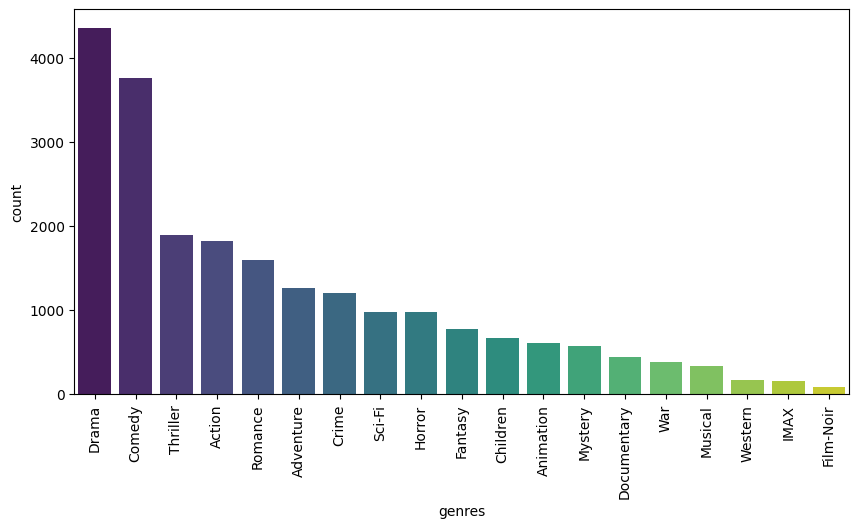

In [7]:
genres_counts_df = pd.DataFrame([genres_counts]).T.reset_index()
genres_counts_df.columns = ['genres', 'count']
genres_counts_df = genres_counts_df.sort_values(by='count', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x='genres', y='count', data=genres_counts_df, palette='viridis')
plt.xticks(rotation=90)
plt.show()

The plot above shows that `Drama` and `Comedy` are the two most popular movie genres. The least popular movie genres are `Westerns`, `IMAX`, and `Film-Noir`.

#### Parsing out year from movie title

In our dataset, movie titles currently the year of release appended to it in brackets, e.g., `"Toy Story (1995)"`. We want to use the year of a movie's release as a feature, so let's parse it out from the title string and create a new `year` column for it.

We can start with writing a function that parses out year from the title string. In the code below, `extract_year_from_title()` takes in the title and does the following:

- generates a list by splitting out each word by spaces (e.g., `["Toy", "Story", "(1995)"]`)
- gets the last element of the list (e.g., `"(1995)"`)
- if the last element has brackets surrounding it, these `()` brackets get stripped (e.g., `"1995"`)
- converts the year into an integer 

In [8]:
import re 

def extract_year_from_title(title):
    t = title.split(' ')
    year = None
    if re.search(r'\(\d+\)', t[-1]):
        year = t[-1].strip('()')
        year = int(year)
    return year

We can test out this function with our example of `"Toy Story (1995)"`:

In [9]:
title = "Toy Story (1995)"
year = extract_year_from_title(title)
print(f"Year of release: {year}")
print(type(year))

Year of release: 1995
<class 'int'>


Our function `extract_year_from_title()` works! It's able to successfully parse out year from the title string as shown above. We can now apply this to all titles in our `movies` dataframe using Pandas' [apply()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html) method.

In [10]:
movies['year'] = movies['title'].apply(extract_year_from_title)
movies.head()

,movieId,title,genres,year
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995.0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995.0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995.0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995.0
4,5,Father of the Bride Part II (1995),[Comedy],1995.0


#### How many different years of release are covered in our dataset?

In [11]:
movies['year'].nunique()

106

There are over 100 years of release in our dataset. Let's collapse this down into decades to get a general sense of when movies were released in our dataset. 

#### What was the most popular decade of movie release?

Before we begin, we'll remove all movies with null year.

In [12]:
print(f"Original number of movies: {movies['movieId'].nunique()}")

Original number of movies: 9742


In [13]:
movies = movies[~movies['year'].isnull()]
print(f"Number of movies after removing null years: {movies['movieId'].nunique()}")

Number of movies after removing null years: 9718


We filtered out 24 movies that don't have a year of release. 

Now, there are two ways to get the decade of a year:

1. converting year to string, replacing the fourth (last) number with a 0
2. rounding year down to the nearest 10 

We'll show both implementations in the code below:

In [14]:
x = 1995

def get_decade(year):
    year = str(year)
    decade_prefix = year[0:3] # get first 3 digits of year
    decade = f'{decade_prefix}0' # append 0 at the end
    return int(decade)

get_decade(x)

1990

In [15]:
def round_down(year):
    return year - (year%10)

round_down(x)

1990

The two functions `get_decade()` and `round_down()` both accomplish the same thing: they both get the decade of a year.

We can apply either of these functions to all years in our `movies` dataset. We'll use `round_down()` in this example to a create a new column called `'decade'`:

In [16]:
movies['decade'] = movies['year'].apply(round_down)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

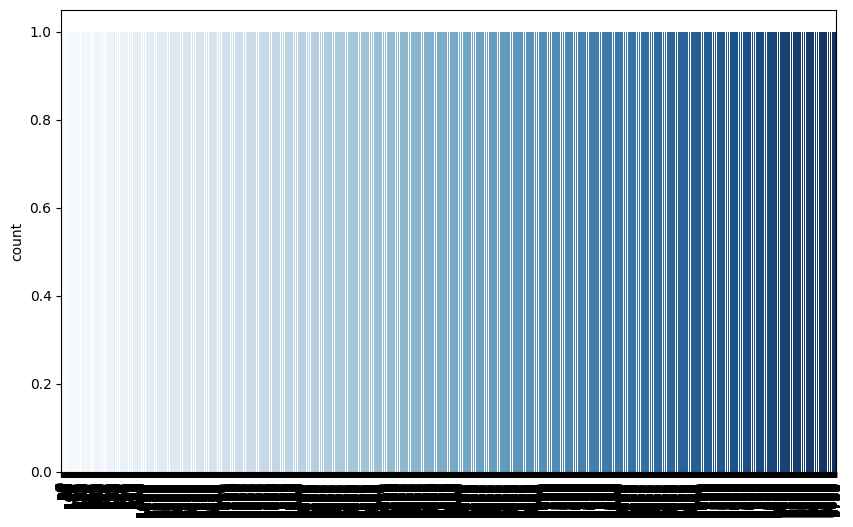

In [17]:
plt.figure(figsize=(10,6))
sns.countplot(movies['decade'], palette='Blues')
plt.xticks(rotation=90)

As we can see from the plot above, the most common decade is the 2000s followed by the 1990s for movies in our dataset.

### Step 4: Transforming the Data

In order to build a content-based filtering recommender, we need to set up our dataset so that rows represent movies and columns represent features (i.e., genres and decades).

First, we need to manipulate the `genres` column so that each genre is represented as a separate binary feature. "1" indicates that the movie falls under a given genre, while "0" does not. 

In [18]:
genres = list(genres_counts.keys())

for g in genres:
    movies[g] = movies['genres'].transform(lambda x: int(g in x))

Let's take a look at what the movie genres columns look like:

In [19]:
movies[genres].head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir
0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Great! Our genres columns are represented as binary feautres. The next step is to wrangle our `decade` column so that each decade has its own column. We can do this using pandas' [get_dummies()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) function, which works by creating a categorical variable into binary variables.

In [20]:
movie_decades = pd.get_dummies(movies['decade'])
movie_decades.head()

,1900.0,1910.0,1920.0,1930.0,1940.0,1950.0,1960.0,1970.0,1980.0,1990.0,2000.0,2010.0
0,False,False,False,False,False,False,False,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,False,False,False,False,False,True,False,False


Now, let's create a new `movie_features` dataframe by combining our genres features and decade features. We can do this using pandas' [concat](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html) function which concatenates (appends) genres and decades into a single dataframe.

In [21]:
movie_features = pd.concat([movies[genres], movie_decades], axis=1)
movie_features.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,...,1920.0,1930.0,1940.0,1950.0,1960.0,1970.0,1980.0,1990.0,2000.0,2010.0
0,1,1,1,1,1,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,False
1,1,0,1,0,1,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,False
2,0,0,0,1,0,1,0,0,0,0,...,False,False,False,False,False,False,False,True,False,False
3,0,0,0,1,0,1,1,0,0,0,...,False,False,False,False,False,False,False,True,False,False
4,0,0,0,1,0,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,False


Our `movie_features` dataframe is ready. The next step is to start building our recommender. 

### Step 5: Building a "Similar Movies" Recommender Using Cosine Similarity

We're going to build our item-item recommender using a similarity metric called [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). 

Cosine similarity looks at the cosine angle between two vectors (e.g., $A$ and $B$). The smaller the cosine angle, the higher the degree of similarity between $A$ and $B$. You can calculate the similarity between $A$ and $B$ with this equation:

$$\cos(\theta) = \frac{A\cdot B}{||A|| ||B||}$$

In this tutorial, we're going to use scikit-learn's cosine similarity [function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) to generate a cosine similarity matrix of shape $(n_{\text{movies}}, n_{\text{movies}})$. With this cosine similarity matrix, we'll be able to extract movies that are most similar to the movie of interest.

In [22]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_features, movie_features)
print(f"Dimensions of our movie features cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our movie features cosine similarity matrix: (9718, 9718)


As expected, after passing the `movie_features` dataframe into the `cosine_similarity()` function, we get a cosine similarity matrix of shape $(n_{\text{movies}}, n_{\text{movies}})$.

This matrix is populated with values between 0 and 1 which represent the degree of similarity between movies along the x and y axes.

### Let's create a movie finder function

Let's say we want to get recommendations for movies that are similar to Jumanji. To get results from our recommender, we need to know the exact title of a movie in our dataset. 

In our dataset, Jumanji is actually listed as `'Jumanji (1995)'`. If we misspell Jumanji or forget to include its year of release, our recommender won't be able to identify which movie we're interested in.  

To make our recommender more user-friendly, we can use a Python package called [fuzzywuzzy](https://pypi.org/project/fuzzywuzzy/) which will find the most similar title to a string that you pass in. Let's create a function called `movie_finder()` which take advantage of `fuzzywuzzy`'s string matching algorithm to get the most similar title to a user-inputted string. 

In [23]:
from fuzzywuzzy import process

def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

C:\Users\Vi Le\AppData\Roaming\Python\Python312\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Let's test this out with our Jumanji example. 

In [24]:
title = movie_finder('juminji')
title

'Jumanji (1995)'

To get relevant recommendations for Jumanji, we need to find its index in the cosine simialrity matrix. To identify which row we should be looking at, we can create a movie index mapper which maps a movie title to the index that it represents in our matrix. 

Let's create a movie index dictionary called `movie_idx` where the keys are movie titles and values are movie indices:

In [25]:
movie_idx = dict(zip(movies['title'], list(movies.index)))
idx = movie_idx[title]
idx

1

Using this handy `movie_idx` dictionary, we know that Jumanji is represented by index 1 in our matrix. Let's get the top 10 most similar movies to Jumanji.

In [26]:
n_recommendations=10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_movies = [i[0] for i in sim_scores]

`similar_movies` is an array of indices that represents Jumanji's top 10 recommendations. We can get the corresponding movie titles by either creating an inverse `movie_idx` mapper or using `iloc` on the title column of the `movies` dataframe.

In [27]:
print(f"Because you watched {title}:")
movies['title'].iloc[similar_movies]

Because you watched Jumanji (1995):


53                     Indian in the Cupboard, The (1995)
109                     NeverEnding Story III, The (1994)
1618    NeverEnding Story II: The Next Chapter, The (1...
8719                   The Cave of the Golden Rose (1991)
9565                            Gulliver's Travels (1996)
1357                                Borrowers, The (1997)
1565                                     Tall Tale (1995)
2539                We're Back! A Dinosaur's Story (1993)
5624    Kirikou and the Sorceress (Kirikou et la sorci...
5975    Asterix & Obelix vs. Caesar (Astérix et Obélix...
Name: title, dtype: object

Cool! These recommendations seem pretty relevant and similar to Jumanji. The first 5 movies are family-friendly films from the 90s. 

We can test our recommender further with other movie titles. For your convenience, I've packaged the steps into a single function which takes in the movie title of interest and number of recommendations. 

In [28]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Recommendations for {title}:")
    print(movies['title'].iloc[similar_movies])

In [29]:
get_content_based_recommendations('aladin', 5)

Recommendations for Aladdin (1992):
1177                                      Hercules (1997)
95                          Muppet Treasure Island (1996)
673     Land Before Time III: The Time of the Great Gi...
1757                                 Bug's Life, A (1998)
3727                Ferngully: The Last Rainforest (1992)
Name: title, dtype: object
